# Pharmaceutical Sales prediction 
### Exploration of customer purchasing behavior

### Overview

You work at Rossmann Pharmaceuticals as a data scientist. The finance team wants to forecast sales in all their stores across several cities six weeks ahead of time. Managers in individual stores rely on their years of experience as well as their personal judgement to forecast sales. The data team identified factors such as promotions, competition, school and state holidays, seasonality, and locality as necessary for predicting the sales across the various stores. Your job is to build and serve an end-to-end product that delivers this prediction to Analysts in the finance team.

### Data

The data and feature description for this challenge can be found here (https://www.kaggle.com/c/rossmann-store-sales/data).

# Table of content
1.  Importing the required libraries 
2.  Data importation
3.  Data understanding and processing   
    * Train dataset
    * Store dataset
    * Test dataset
4. Exploratory data analysis

# Importing libraries

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

import dataframe_image as dfi

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

import os

In [2]:
# set the path of the raw data
raw_data_path = os.path.join(os.path.pardir, 'data', 'raw')
train_file_path = os.path.join(raw_data_path, 'train.csv')
test_file_path = os.path.join(raw_data_path, 'test.csv')
store_file_path = os.path.join(raw_data_path, 'store.csv')

In [3]:
# read the data with all default parameters
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
store_df = pd.read_csv(store_file_path)

# Exploratory Data Analysis

# Basic Structure

## Test set

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [5]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
test_df.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [7]:
### Dealing with missing values
test_df['Open'].value_counts()
test_df.loc[test_df.Open.isnull(), "Open"] = 1
test_df['Open'].isnull().sum()

0

In [8]:
# converting the 'Date column to date format'
test_df["Date"] = pd.to_datetime(test_df["Date"],format = "%Y-%m-%d")

# extracting the parameters of interest;
test_df['day'] = test_df['Date'].dt.day
test_df['month'] = test_df['Date'].dt.month
test_df['year'] = test_df['Date'].dt.year

Taking a closer look at our variables, StateHoliday have some inconsistencies. It has `0` representing <strong>None</strong>. Therefore we will end up having `a = public holiday`, `b = Easter holiday`, `c = Christmas`, `0 = None`. For comformity with the train set dataset, we will convert `0` to `o`.

In [9]:
test_df["StateHoliday"].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [10]:
test_df["StateHoliday"].replace({"0":"o"}, inplace=True)

## Train set

In [12]:
print("Shape of train set: ", train_df.shape)
train_df.head()

Shape of train set:  (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


### Feature Description

| Feature          | description |
| ---------------- | ------------|
| `Store`                            | a unique Id for each store. |
| `Customers`      | the number of customers in a given day |
| `Open`           | an indicator for whether the store wa open: 0 = closed, 1 = open |
| `Promo`          | indicates whether a store is running a promo on that day |
| `StateHoliday`   | indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays |
| `SchoolHoliday`  | indicates if the (Store, Date) was affected by the closure of public schools |
| `Date`           | date


In [13]:
train_df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [14]:
# checking for missing values
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Apparently there is no missing values in train set!

Extracting dates from variable `Date`

In [15]:
# converting the 'Date' column to date format
train_df['Date'] = pd.to_datetime(train_df['Date'], format = '%Y-%m-%d')

# extracting the parameters of interest
train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month
train_df['Year'] = train_df['Date'].dt.year
train_df['WeekOfYear'] = train_df['Date'].dt.weekofyear

In [16]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,31,7,2015,31
1,2,5,2015-07-31,6064,625,1,1,0,1,31,7,2015,31
2,3,5,2015-07-31,8314,821,1,1,0,1,31,7,2015,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,7,2015,31
4,5,5,2015-07-31,4822,559,1,1,0,1,31,7,2015,31


In [18]:
# rearanging columns
train_df = train_df[["Store","Date","Day","Month","Year","DayOfWeek","WeekOfYear","Customers","Open","Promo","StateHoliday","SchoolHoliday","Sales"]]

In [19]:
train_df.head(3)

,Store,Date,Day,Month,Year,DayOfWeek,WeekOfYear,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,2015-07-31,31,7,2015,5,31,555,1,1,0,1,5263
1,2,2015-07-31,31,7,2015,5,31,625,1,1,0,1,6064
2,3,2015-07-31,31,7,2015,5,31,821,1,1,0,1,8314


In [20]:
train_df["StateHoliday"].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

`StateHoliday` has has two 0 (str and int). Therefore we neeed to correct this where;
`a = public holiday`, `b = Easter holiday`, `c = Christmas`, `o = None`

In [21]:
train_df["StateHoliday"].replace({0:"o","0":"o"},inplace = True)

In [22]:
# Finding sales per person
train_df['SalePerCustomer'] = train_df['Sales']/train_df['Customers']
train_df['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### ECDF : emprical cumulative distribution function
`To get the first impression about continuous variables in the data, we can plot ECDF`

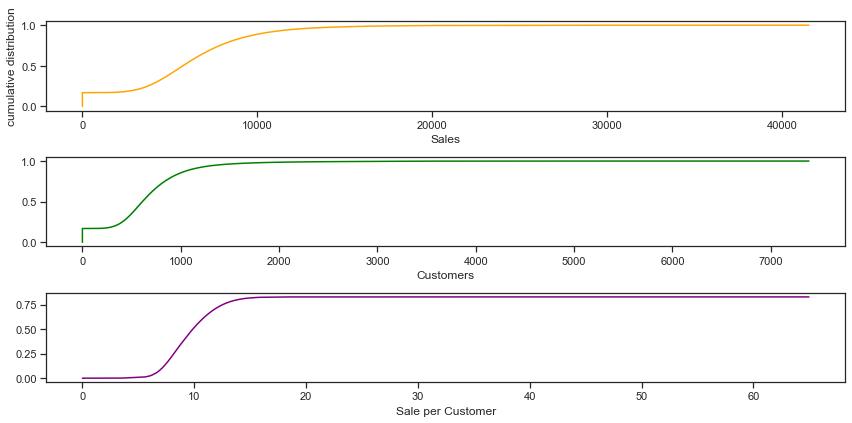

In [23]:
sns.set(style = "ticks") 
o = 'orange' # basic color for plots
g = 'green'
p = 'purple'
plt.figure(figsize = (12, 6))

# first plot for Sales
plt.subplot(311)
cdf = ECDF(train_df['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color=o);
plt.xlabel('Sales'); plt.ylabel('cumulative distribution');

# second plot for Customers
plt.subplot(312)
cdf = ECDF(train_df['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color=g);
plt.xlabel('Customers'); 

# third plot for SalePerCustomer
plt.subplot(313)
cdf = ECDF(train_df['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color=p);
plt.xlabel('Sale per Customer'); 

plt.tight_layout()

About 20% of data has zero amount of sales/customers that we need to deal with. Almost 80% of time daily amount of sales was less than 1000. Some stores have registered zero sales. What could be the cause? 
Let's find out.

# Dealing with missing values

## Closed stores and zero sales stores

In [24]:
# closed stores
train_df[(train_df.Open == 0) & (train_df.Sales == 0)].shape

(172817, 14)

There are 172817 closed stores in the data. It is about 15% of the total amount observations. To avoid biased forecasts, we drop these values.

What about opened stores with zero sales?

In [25]:
# opened stores with zero sales
zero_sales = train_df[(train_df.Open != 0) & (train_df.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head()

In total:  (54, 14)


,Store,Date,Day,Month,Year,DayOfWeek,WeekOfYear,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,SalePerCustomer
86825,971,2015-05-15,15,5,2015,5,20,0,1,0,o,1,0,NaN
142278,674,2015-03-26,26,3,2015,4,13,0,1,0,o,0,0,NaN
196938,699,2015-02-05,5,2,2015,4,6,0,1,1,o,0,0,NaN
322053,708,2014-10-01,1,10,2014,3,40,0,1,1,o,0,0,NaN
330176,357,2014-09-22,22,9,2014,1,39,0,1,0,o,0,0,NaN


There were opened stores with no sales on working days. We can assume there were external factors involved.

In [26]:
print("Closed stores and days which did not have sales won't be counted into forecasts.")
train_df = train_df[(train_df["Open"] !=0) & (train_df["Sales"] != 0)]

print("Dataframe shape: ", train_df.shape)

Closed stores and days which did not have sales won't be counted into forecasts.
Dataframe shape:  (844338, 14)


## Working with outliers

### Feature : Sales

In [27]:
train_df['Sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

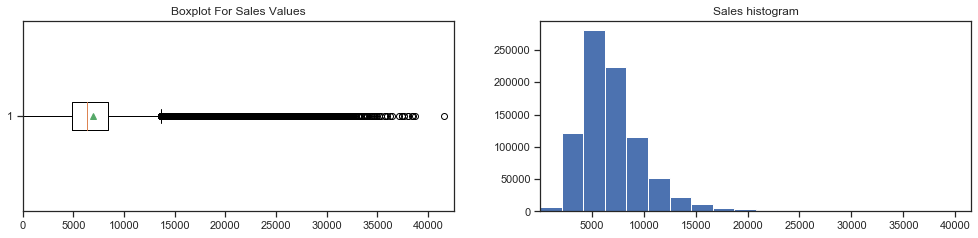

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
# Plotting a boxplot
axes[0].boxplot(train_df.Sales, showmeans=True,vert=False)
axes[0].set_xlim(0,max(train_df["Sales"]+1000))
axes[0].set_title('Boxplot For Sales Values')
# Plotting a histogram
axes[1].hist(train_df.Sales, cumulative=False, bins=20)
axes[1].set_title("Sales histogram")
axes[1].set_xlim((min(train_df.Sales), max(train_df.Sales)))

#plt.savefig("Sales_outlier.png")
plt.show

Distribution of sales is skewed to the right, which means there are outliers

### Feature : Customers

In [30]:
train_df["Customers"].describe()

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

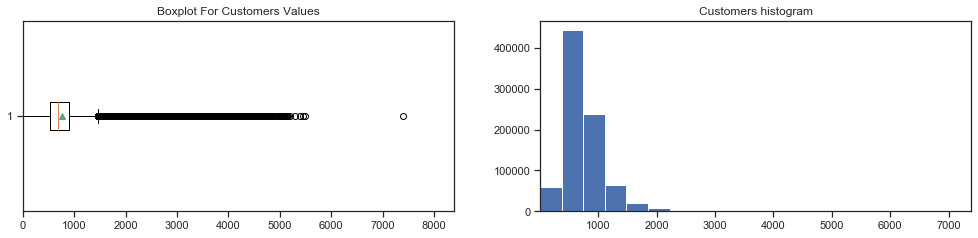

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
# Plotting a boxplot
axes[0].boxplot(train_df.Customers, showmeans=True,vert=False)
axes[0].set_xlim(0,max(train_df["Customers"]+1000))
axes[0].set_title('Boxplot For Customers Values')

# Plotting a histogram
axes[1].hist(train_df.Customers, cumulative=False, bins=20)
axes[1].set_title("Customers histogram")
axes[1].set_xlim((min(train_df.Customers), max(train_df.Customers)))

#plt.savefig("Customer_outlier.png")
plt.show

Distribution of customers is skewed to the right, which means there are outliers

## Store set

# Description of variables of the store data
| variable         | description |
| ---------------- | ------------|
| `Store`                            | a unique Id for each store. |
| `StoreType`                        | differentiates between 4 different store models: a, b, c, d. |
| `Assortment`                       | describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here. |
| `CompetitionDistance`              | distance in meters to the nearest competitor store. |
| `CompetitionOpenSinceMonth`        | gives the approximate  month of the time the nearest competitor was opened. |
| `CompetitionOpenSinceYear`         | gives the approximate year of the time the nearest competitor was opened. |
| `Promo2`                           | Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating. |
| `Promo2Since[Year/Week]`           | describes the year and calendar week when the store started participating in Promo2. |
| `PromoInterval`                    |  describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. |   


In [16]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [33]:
# checking for missing values
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Dealing with missing values for store data set

### Feature : CompetitionDistance

In [34]:
store_df[store_df.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


No particular pattern observed. We replace NaN with the median values

In [35]:
CompetitionDistance_median = store_df['CompetitionDistance'].median()
store_df.CompetitionDistance.fillna(CompetitionDistance_median, inplace=True)

In [37]:
store_df['CompetitionDistance'].isnull().sum()

0

### Feature : Promo2SinceWeek

In [38]:
_ = store_df[pd.isnull(store_df.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

Since there is no Promo2, then there's no information about it. We can replace these values by zeros. 
The same goes for variables deducted from the competition.

In [39]:
# replacing NA's by 0.
store_df.fillna(0, inplace=True)

In [40]:
store_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## Joining train_df and store_df

In [41]:
print("Joining train set store set.")

train_store = pd.merge(train_df, store_df, how='inner', on='Store')

print("Dataframe Shape: ", train_store.shape)
train_store.head()

Joining train set store set.
Dataframe Shape:  (844338, 23)


,Store,Date,Day,Month,Year,DayOfWeek,WeekOfYear,Customers,Open,Promo,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2015-07-31,31,7,2015,5,31,555,1,1,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,2015-07-30,30,7,2015,4,31,546,1,1,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,2015-07-29,29,7,2015,3,31,523,1,1,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2015-07-28,28,7,2015,2,31,560,1,1,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,2015-07-27,27,7,2015,1,31,612,1,1,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Store Analysis

We look at different levels of StoreType and how the main metric Sale, is ditributed among them

In [42]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [43]:
train_store.groupby('StoreType')['Store']

StoreType B has the highest average of Sales among all others, however there is much less data for it. Let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one

In [44]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


StoreType D goes second after A in both Sales and Customers

What about date periods?

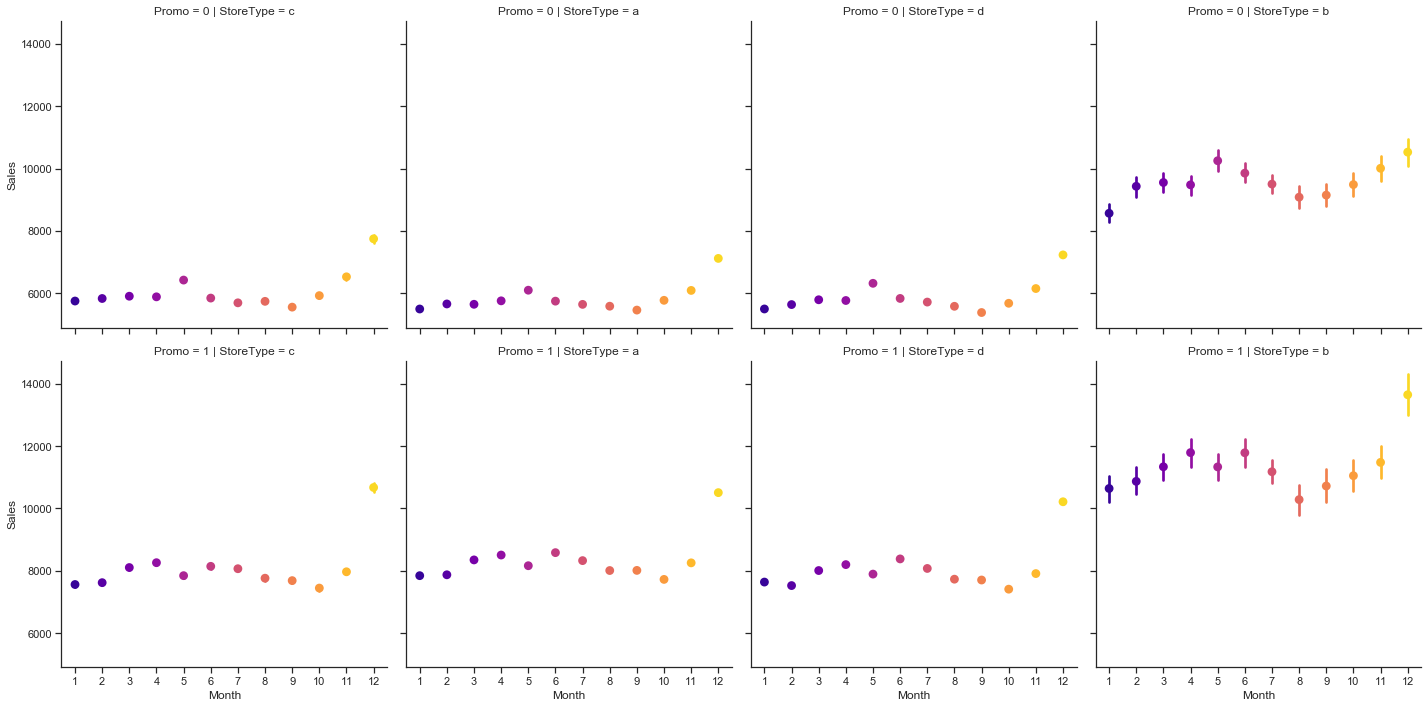

In [46]:
# sales trend

c = '#386B7F'

sns.factorplot(data = train_store, x = 'Month', y = 'Sales',
              col = 'StoreType', # color per store type in cols
              palette = 'plasma',
              #hue = 'StoreType',
              row = 'Promo', # per promo in the store in rows
              color = c)
#plt.savefig('promo.png')
plt.show()

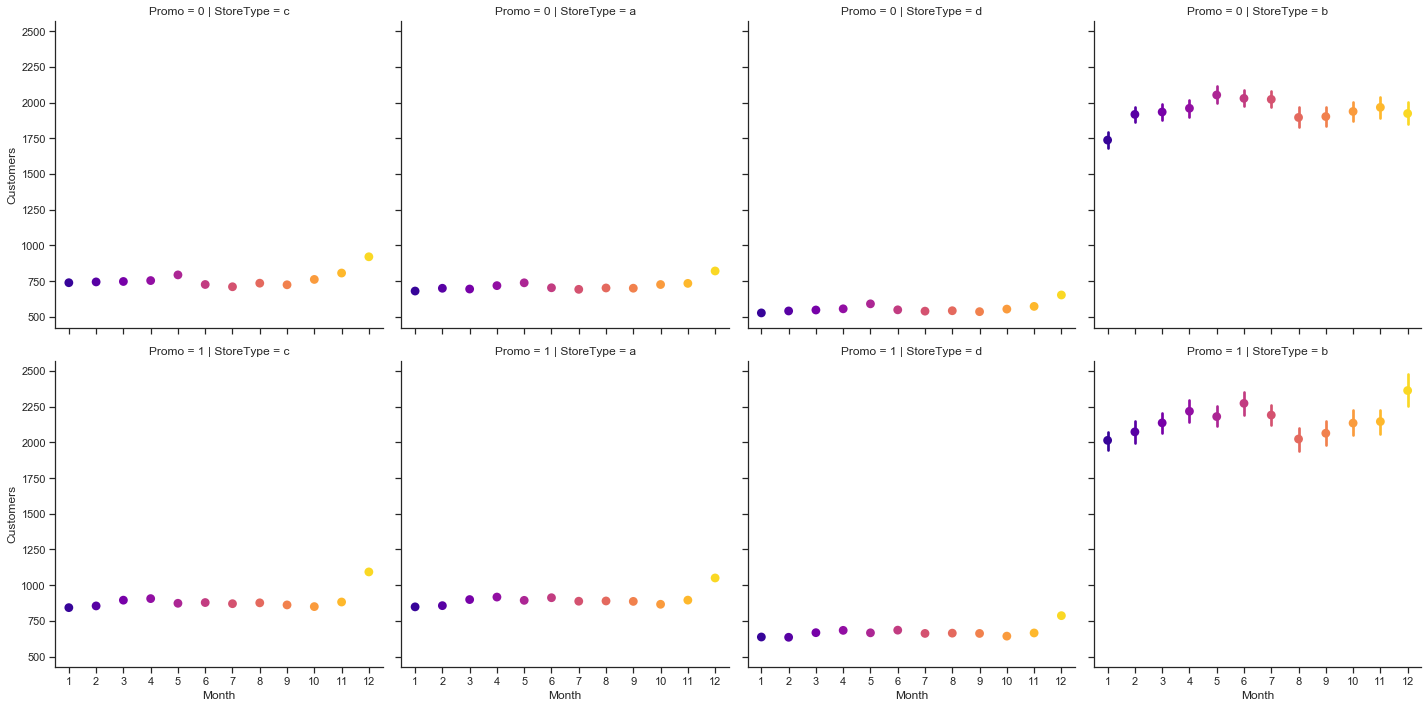

In [47]:
# customer trend

sns.factorplot(data = train_store, x = 'Month', y = 'Customers',
              col = 'StoreType', # color per store type in cols
              palette = 'plasma',
              # hue = 'StoreType',
              row = 'Promo', # per promo in the store in rows
              color = c)
plt.tight_layout()
plt.show()

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType.

<i>At this point, we can already see that sales escalate towards Christmas holidays.</i>

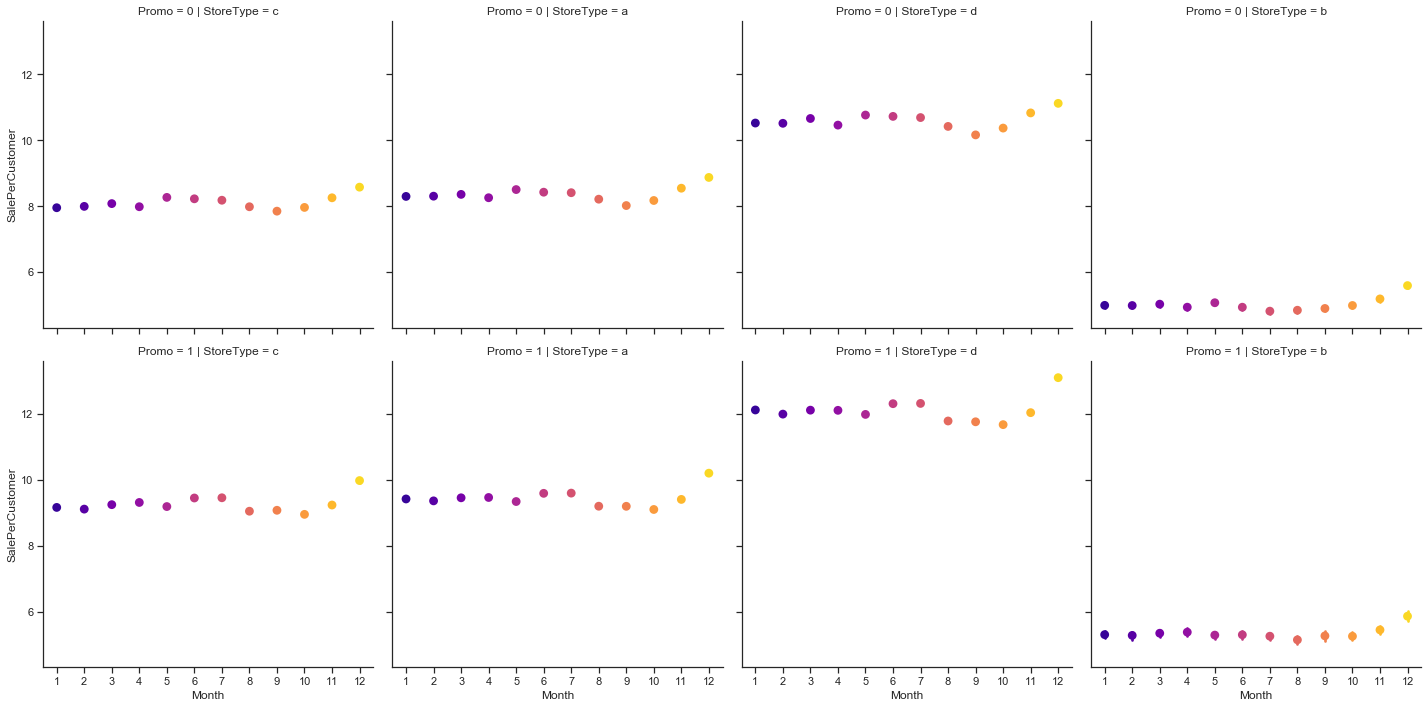

In [48]:
# sale per customer trends
sns.factorplot(data=train_store, x = 'Month', y = 'SalePerCustomer',
              col = 'StoreType',
              palette = 'plasma',
              row = 'Promo',
              color = c)

plt.show()

The first two plots for customers and sales showed that StoreType B as the most selling and performant one, however that is not true in reality. The highest SalePerCustomer amount is observed at the StoreType D, about 10€ without Promo and 12€ with Promo. 

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially in a little quantity. Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

<Figure size 1584x864 with 0 Axes>

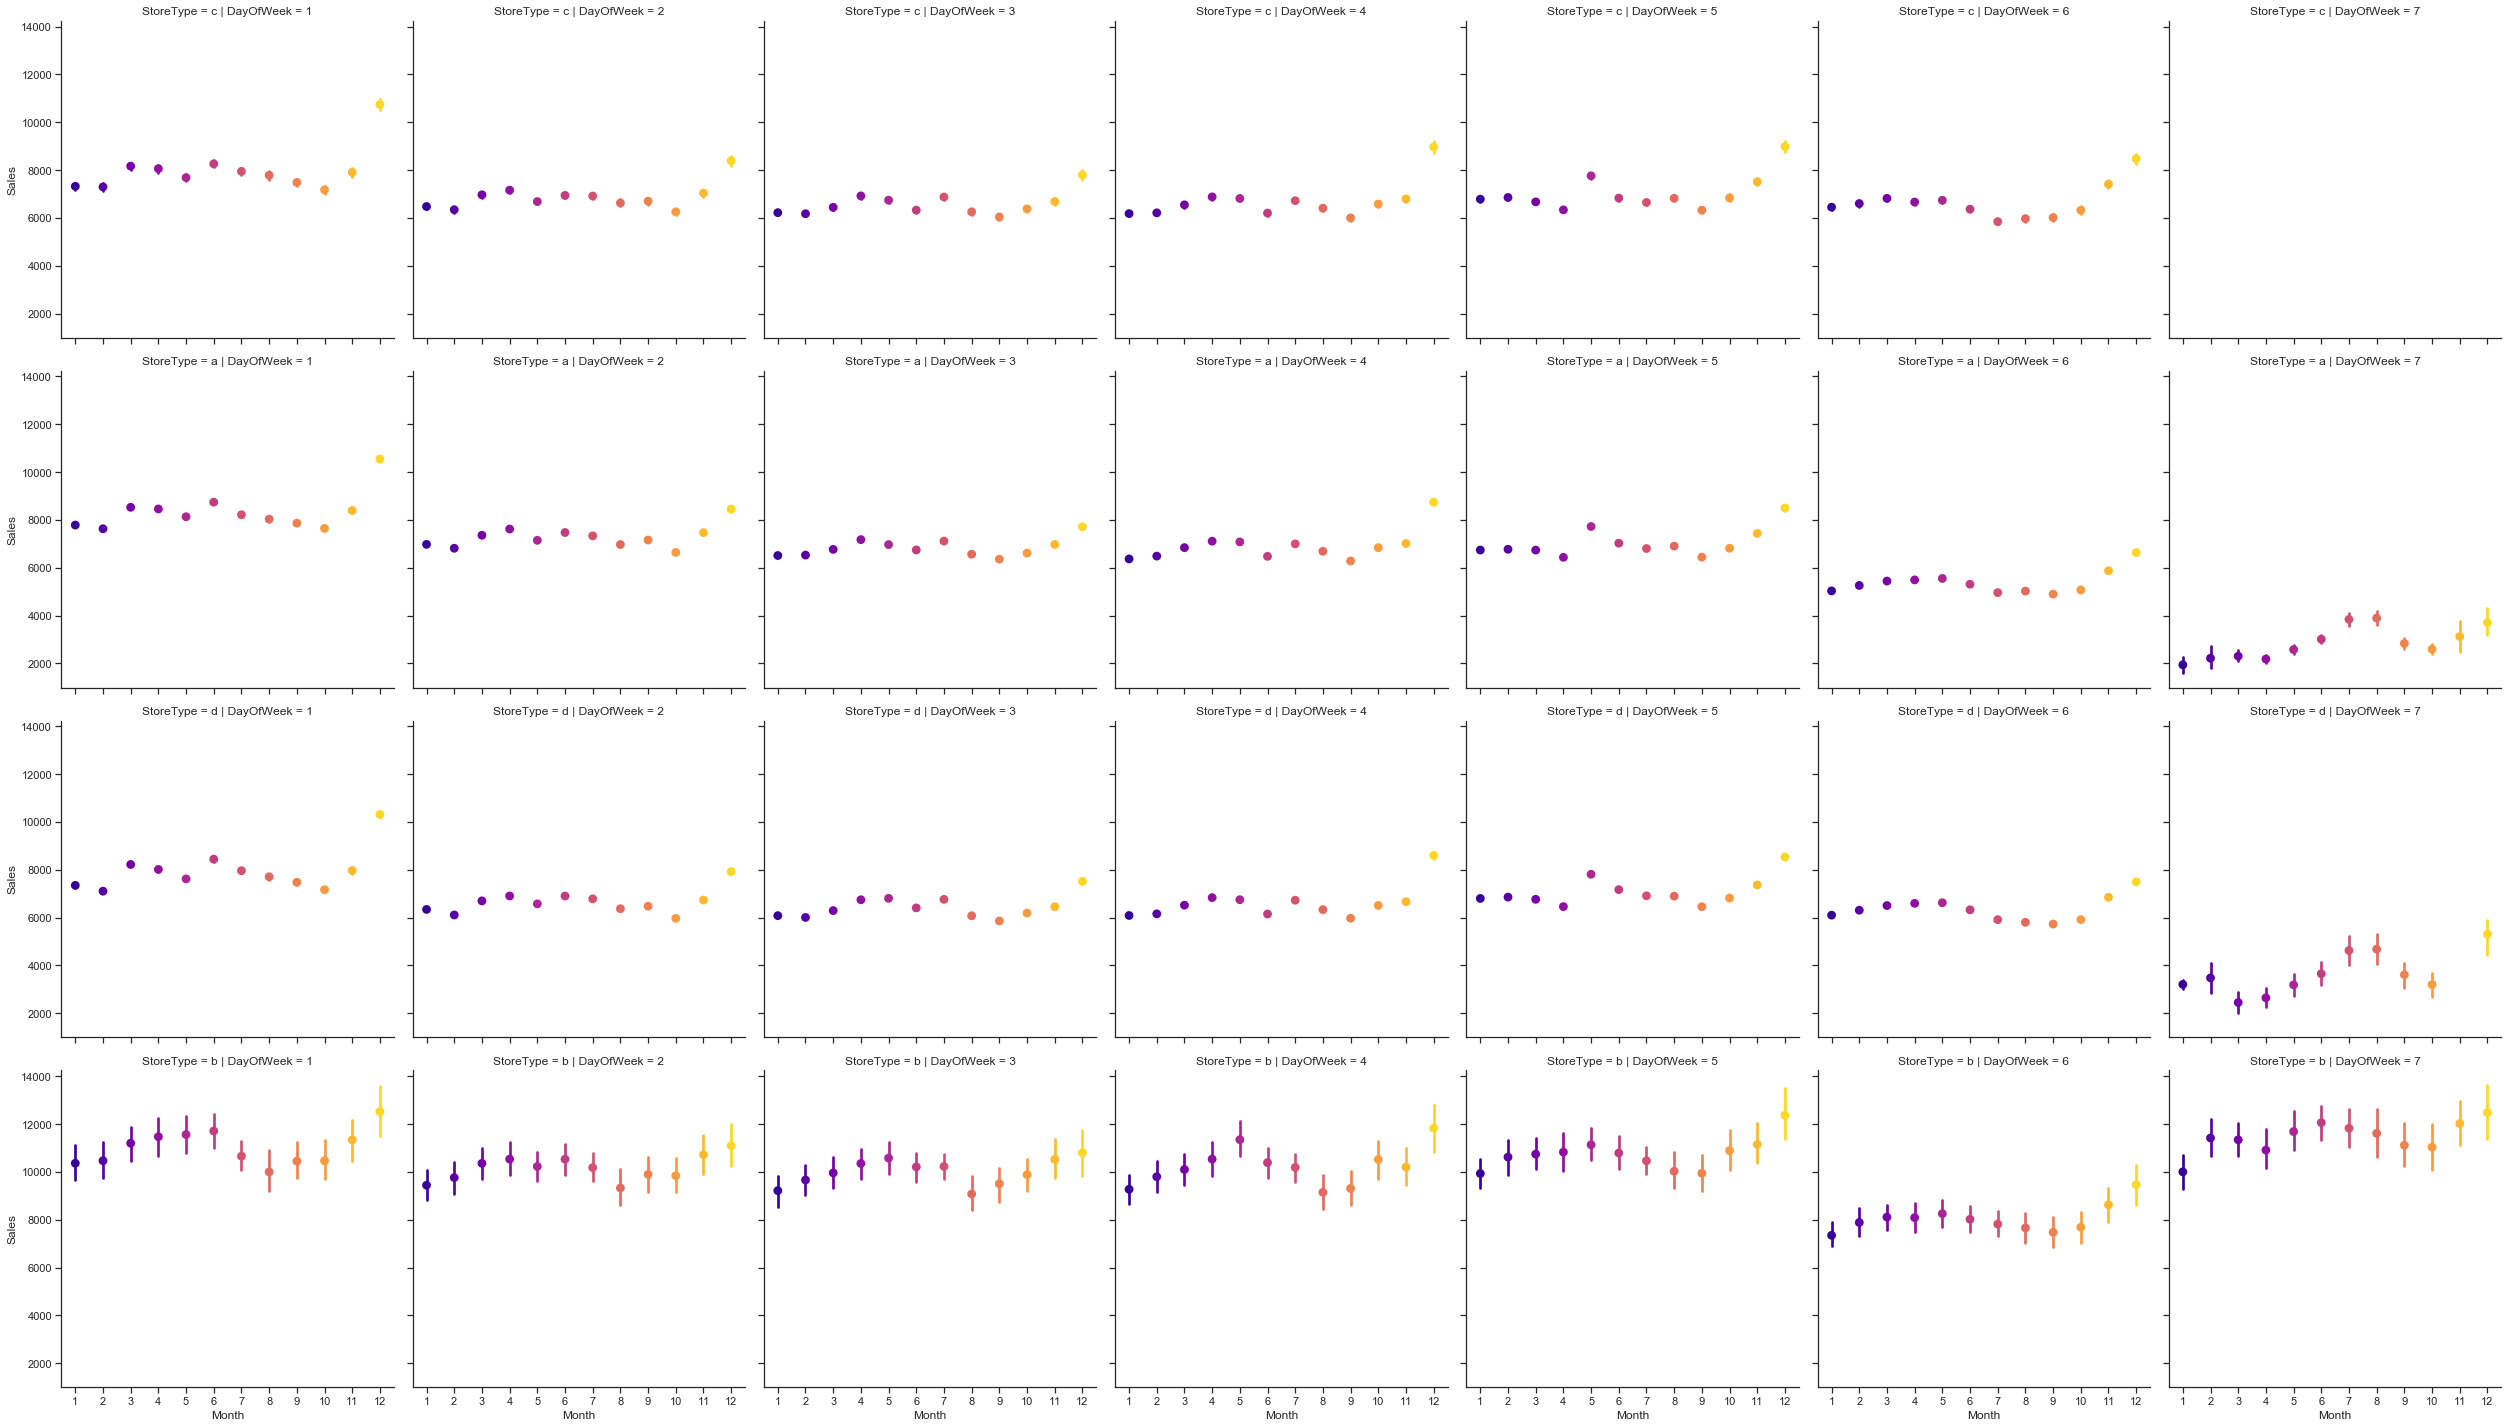

In [50]:
# customers
plt.figure(figsize = (22, 12))

sns.factorplot(data = train_store, x = 'Month', y = 'Sales',
              col = 'DayOfWeek', # per store type in cols
              palette = 'plasma',
              row = 'StoreType', # per store type in rows
              color = c)

#plt.savefig('weekdayopen.png')
plt.show()

store of StoreType C are all closed on Sundays, whereas others are most of the time opened. However, stores of StoreType D are closed on Sundays only from October to December. 

### Stores opened on Sundays

In [51]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

Sales behaviour before, during and after holidays

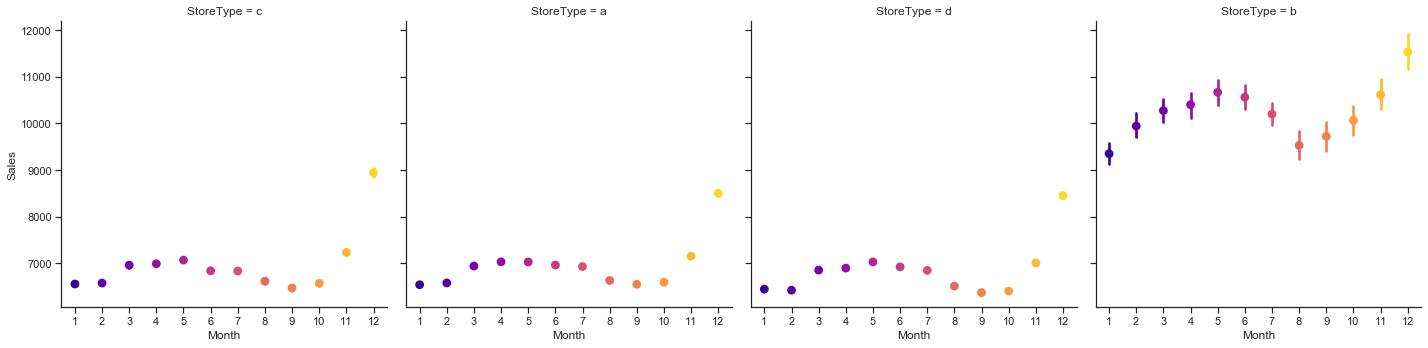

In [53]:
#Sales trend per StateHoliday
'''
a = public holiday, b = Easter holiday, c = Christmas, 0 = None
'''
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               #hue = 'StateHoliday',
               color = c) 
#plt.savefig("sale_per_StateHoliday_trends.png")
plt.show()

## Adding features that describe period of time during which competion and promotion were opened

In [54]:
# competition open time (in months)

train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)

# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace=True)

# average PrompOpen time and ComepetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


The most selling crowded StoreType A does not appear to be the most exposed to competitions. Instead it's a StoreType B, which has the longest running period of promotion.

## Correlation Analysis

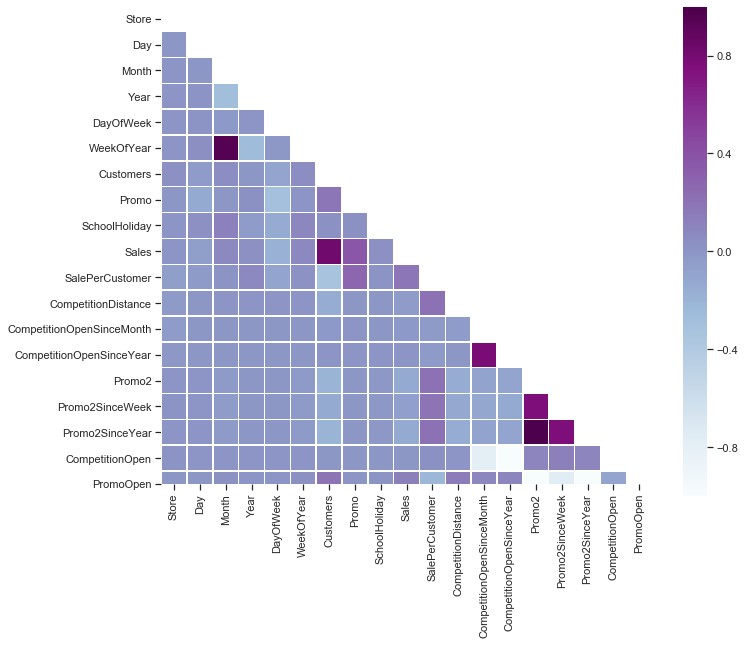

In [55]:
# Computing correlation matrix
# Excluding  'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# setting up matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Drawig heatmap with mask and correct aspect ration
sns.heatmap(corr_all, mask = mask,
           square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.savefig('correlation.png')
plt.show()

There is a strong positive correlation between the amount of Sales andf Customer of a store. We can observe a positive correlation when the store had a running promotion and the amount of Customers.

However, as soon as the store continues a consecutive promotion (Promo 2 equal to 1), the number of Customers and Sales seems to stay at the same level or even decreases, which is described by the pale negative correlation on the heatmap

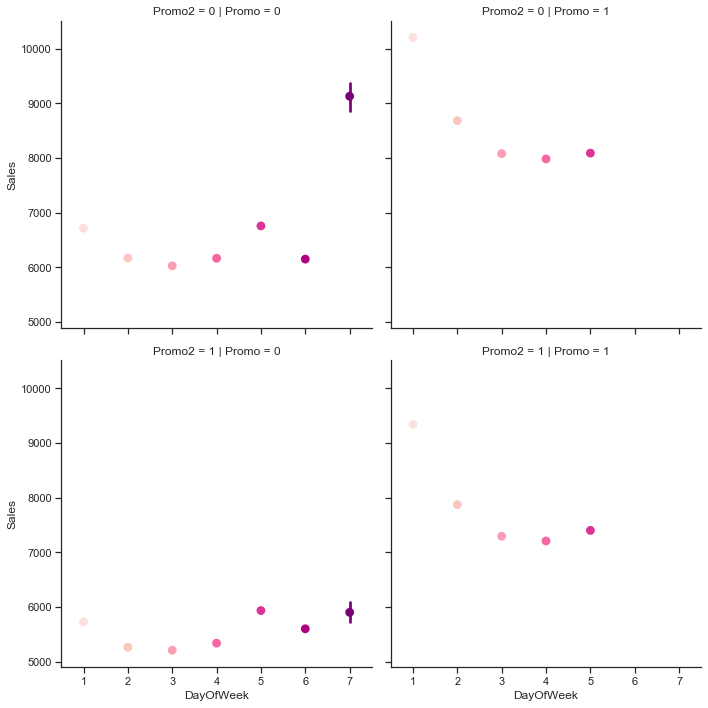

In [56]:
# sale per customer trends

sns.factorplot(data = train_store, x = 'DayOfWeek', y = 'Sales',
              col = 'Promo',
              row = 'Promo2',
              palette = 'RdPu')
#plt.savefig('sale_per_customer.png')
plt.show()

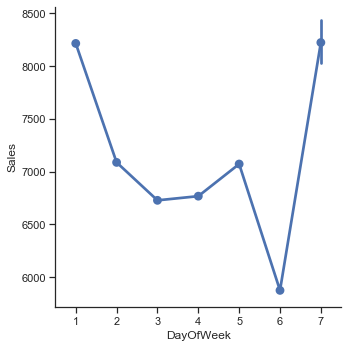

In [58]:
sns.factorplot(data = train_store, x ="DayOfWeek", y = "Sales"
              ,sharex=False)
#plt.savefig("stores_open_2.png")
plt.show()

### Observations
* In case of no promotion, Promo and Promo2 are equal to 0, Sales tend to peak on Sunday. <strong>Note</strong>, StoreType C does not work on Sundays. So it is data mainly from StoreType A, B and D.
* On the contrary, stores that run the promotion tend to make most of the Sales on Monday This same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1)
* Promo2 alone does not seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

## How does assortment type affect sales?

In [60]:
'''
assortments have three types and each store has a defined type and assortment type:
a- means basic things
b- means extra things
c -means extended things so the highest variety of products.
'''
assorted = train_store.groupby("Assortment").agg({"Sales":[sum]})

In [61]:
assorted

,Sales
,sum
Assortment,
a,2945750070
b,70946312
c,2856484241


It is observed that `Assortment a` had the most sales followed by  `Assortment c`.Most customers prefer basic things they are aware of and least interested in the extra things

Examining relationship between a `StoreType` and its respective `Assortment type`.

In [62]:
train_store.groupby(by=["StoreType","Assortment"]).Assortment.count()

StoreType  Assortment
a          a             286028
           c             171014
b          a               6409
           b               8209
           c                942
c          a              58554
           c              54414
d          a              93884
           c             164884
Name: Assortment, dtype: int64

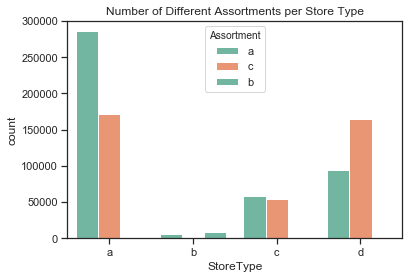

In [63]:
sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], data=train_store,
              palette=sns.color_palette("Set2", n_colors=2)).set_title("Number of Different Assortments per Store Type")
#plt.savefig("ASSORTMENT.png")
plt.show()

Most of the stores have either a assortment type or c assortment type.

We note that StoreType d which had the highest Sales per customer average actually has mostly c assortment type, this is most probably the reason for having this high average in Sales per customer.This is because aving variety in stores always increases the customers spending pattern.

<strong>Examining how the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?</strong>

In [64]:
'''
To see whether the one with very far competition actually make more sales then the one with close competition.
Since `CompetitionDistance` is a continuous variable, we need to first convert it into a categorical variable with 5 different bins.
'''
train_store['CompetitionDist_Cat']=pd.cut(train_store['CompetitionDistance'], 5)

In [65]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [66]:
train_store.groupby(by="CompetitionDist_Cat").Sales.mean()

CompetitionDist_Cat
(-55.84, 15188.0]     6957.360876
(15188.0, 30356.0]    7041.604692
(30356.0, 45524.0]    6471.923562
(45524.0, 60692.0]    5980.114445
(60692.0, 75860.0]    7775.446449
Name: Sales, dtype: float64

In [67]:
train_store.groupby(by="CompetitionDist_Cat").Customers.mean()

CompetitionDist_Cat
(-55.84, 15188.0]     771.345223
(15188.0, 30356.0]    691.574605
(30356.0, 45524.0]    680.101854
(45524.0, 60692.0]    643.988246
(60692.0, 75860.0]    914.574972
Name: Customers, dtype: float64

As shown above, the stores that are the furthest have the highest average sales and number of customers.

In our case, if the store and its competitors all happen to be in city centres, it means the average sales and number of customers will be relatively low

<strong>How does the opening and reopening of new competitions affect stores?</strong>

In [68]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
#train_store_df.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
PromoOpen_time = train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()
PromoOpen_time

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.

# Seasonality

In [70]:
train_time_series = train_df[['Date','Sales']]  
train_time_series = train_time_series.set_index('Date') 

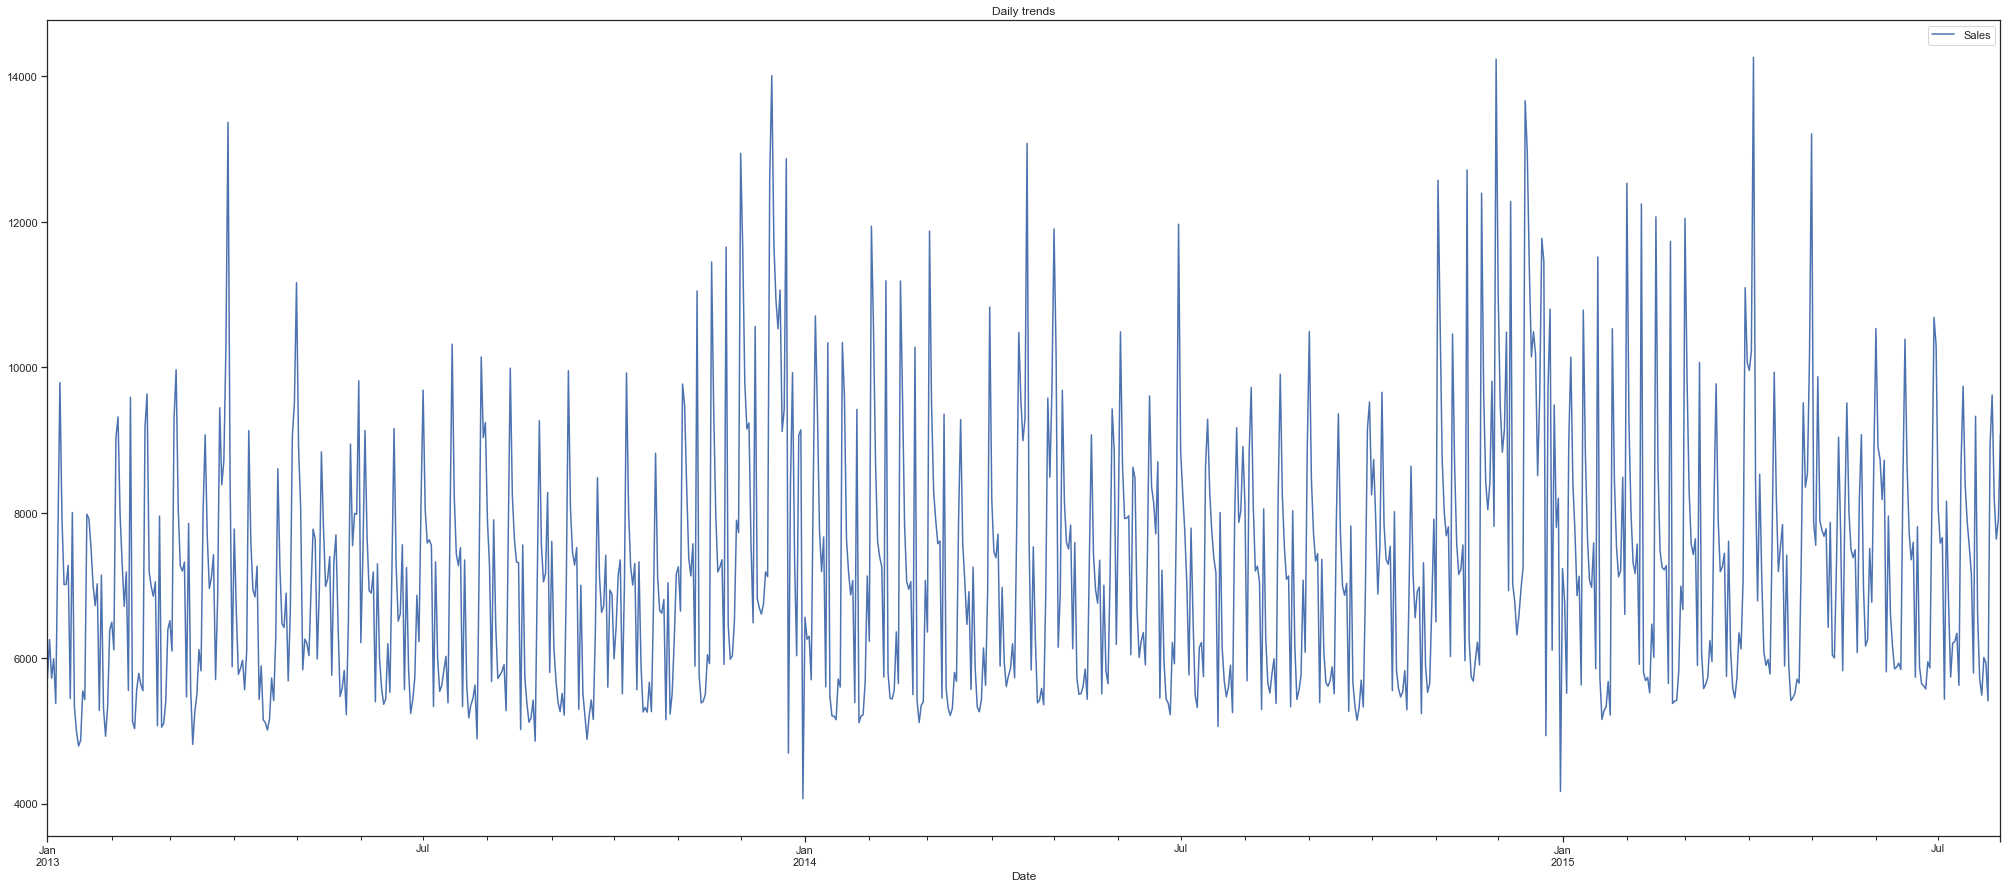

In [71]:
time_series_day = train_time_series.resample('D').mean()
time_series_day.plot(figsize=(35,15))
plt.title("Daily trends")
#plt.savefig("Daily_trends.png")
plt.show()

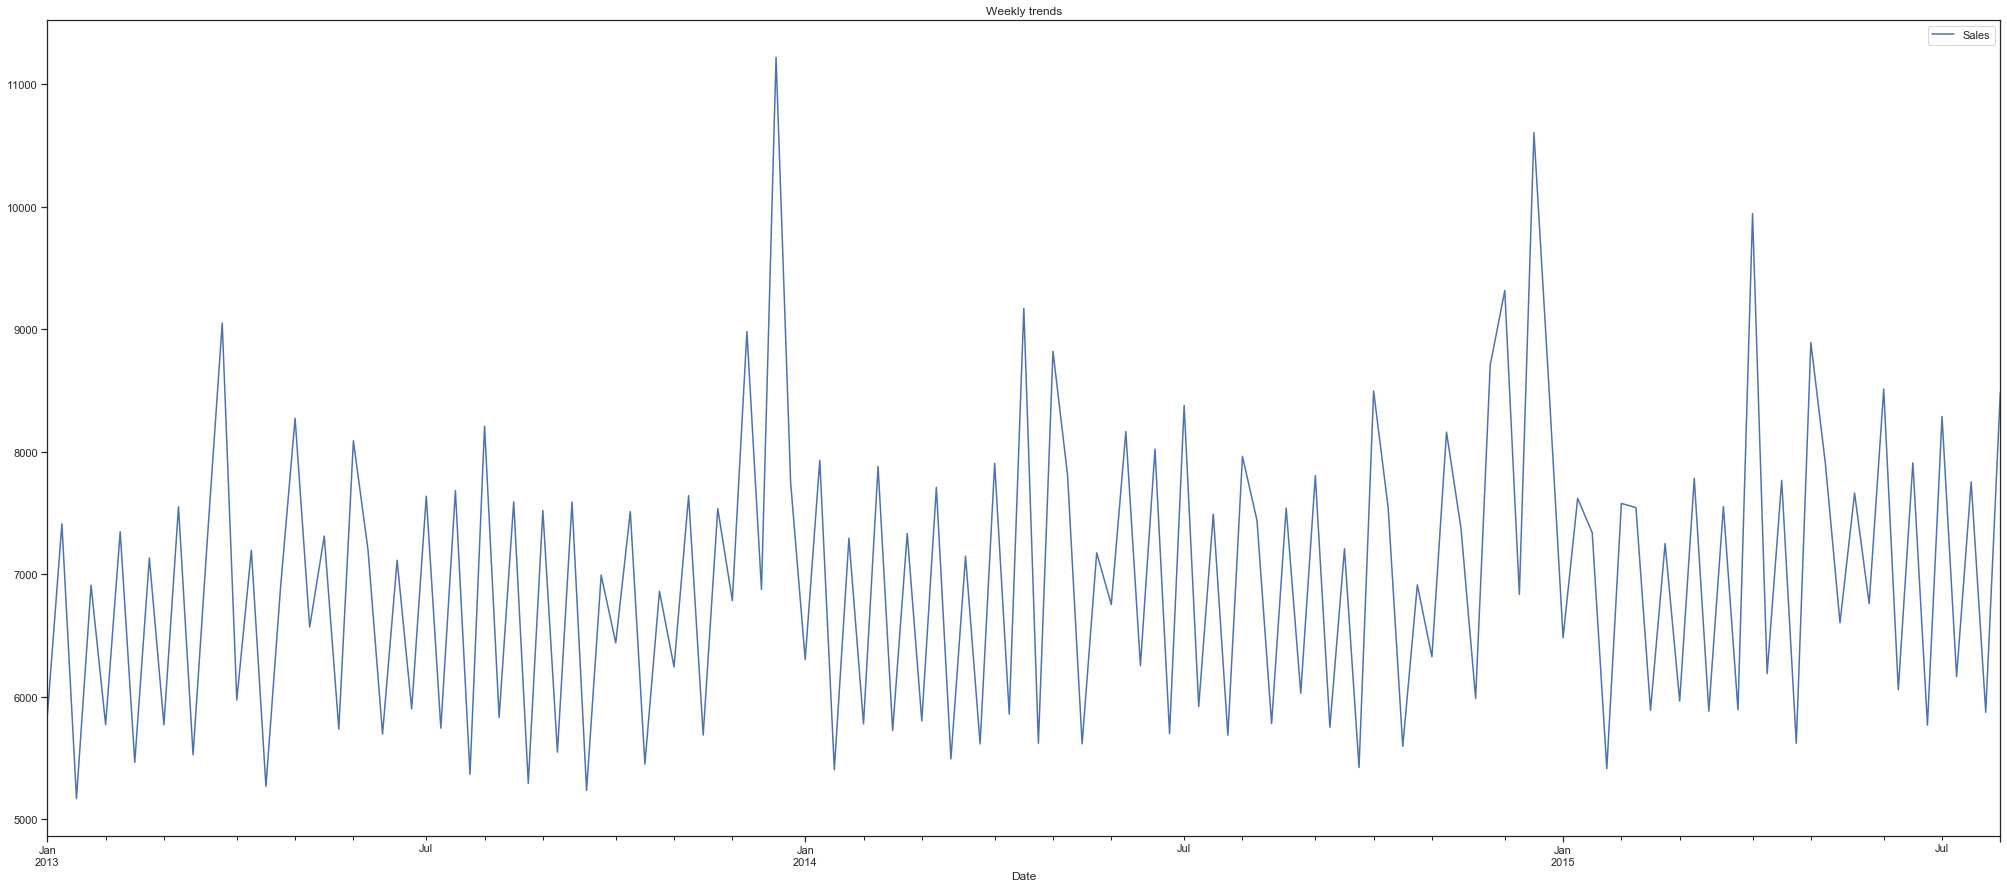

In [72]:
time_series_week = train_time_series.resample('W').mean()
time_series_week.plot(figsize=(35,15))
plt.title("Weekly trends")
#plt.savefig("Seasonal_trends.png")
plt.show()

## Yearly trend

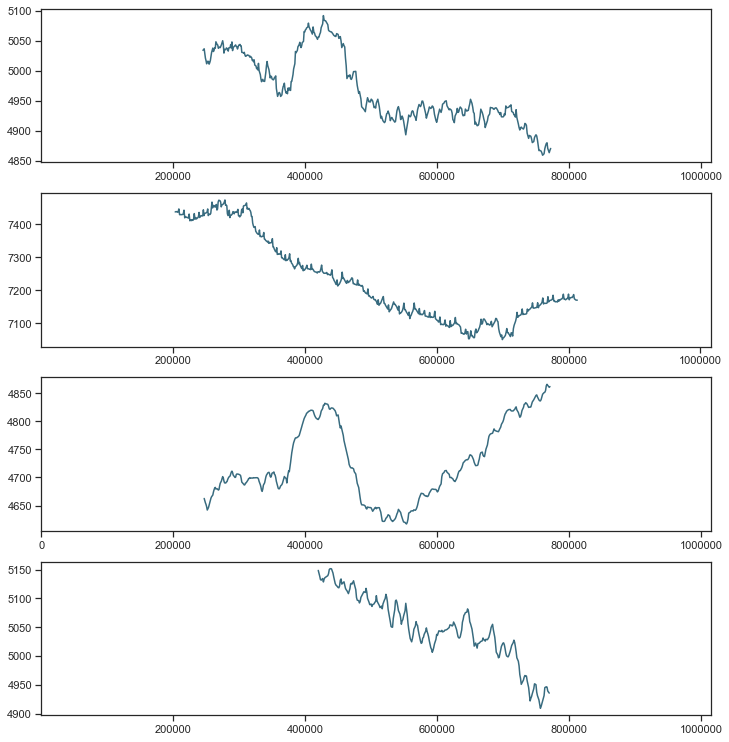

In [73]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))


# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)
plt.show()